<a href="https://colab.research.google.com/github/ahmetnarman/MNIST-GAN/blob/master/DCGAN_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN for MNIST dataset

This Jupyter notebook includes a tensorflow implementation of a DCGAN model for MNIST dataset. It generates synthetic images that are similar to real ones in the dataset.

## Improrting necessary packages

This code has numpy, matplotlib and tensorflow dependencies. The MNIST dataset is directly taken from tensorflow datasets. 

If you are using it on Google Colab, they are imported automatically, no need for installing anything.

In [0]:
import os, time, itertools, imageio, pickle, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

## Necessary functions for the architecture

The activation function, the generator model architecture, and the discriminator model architecture are defined here.

In [0]:
def lrelu(x, th=0.2):
    return tf.maximum(th * x, x)

# G(z)
def generator(x, isTrain=True, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):

        # 1st hidden layer
        conv1 = tf.layers.conv2d_transpose(x, 64, [7, 7], strides=(1, 1), padding='valid')
        lrelu1 = lrelu(tf.layers.batch_normalization(conv1, training=isTrain), 0.2)

        # 2nd hidden layer
        conv2 = tf.layers.conv2d_transpose(lrelu1, 32, [5, 5], strides=(2, 2), padding='same')
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2)

        # 3rd hidden layer
        conv3 = tf.layers.conv2d_transpose(lrelu2, 16, [5, 5], strides=(1, 1), padding='same')
        lrelu3 = lrelu(tf.layers.batch_normalization(conv3, training=isTrain), 0)

        # 4th hidden layer
        #conv4 = tf.layers.conv2d_transpose(lrelu3, 128, [4, 4], strides=(1, 1), padding='same')
        #lrelu4 = lrelu(tf.layers.batch_normalization(conv4, training=isTrain), 0)

        # output layer
        conv5 = tf.layers.conv2d_transpose(lrelu2, 1, [5, 5], strides=(2, 2), padding='same')
        o = tf.nn.tanh(conv5)

        return o

# D(x)
def discriminator(x, isTrain=True, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # 1st hidden layer
        conv1 = tf.layers.conv2d(x, 32, [5, 5], strides=(2, 2), padding='same')
        lrelu1 = lrelu(conv1, 0.2)

        # 2nd hidden layer
        conv2 = tf.layers.conv2d(lrelu1, 64, [5, 5], strides=(2, 2), padding='same')
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2)

        # 3rd hidden layer
        conv3 = tf.layers.conv2d(lrelu2, 128, [5, 5], strides=(1, 1), padding='same')
        lrelu3 = lrelu(tf.layers.batch_normalization(conv3, training=isTrain), 0.2)

        # 4th hidden layer
        #conv4 = tf.layers.conv2d(lrelu3, 128, [5, 5], strides=(1, 1), padding='same')
        #lrelu4 = lrelu(tf.layers.batch_normalization(conv4, training=isTrain), 0.2)

        # output layer
        conv5 = tf.layers.conv2d(lrelu3, 1, [7, 7], strides=(1, 1), padding='valid')
        #drop = tf.layers.dropout(conv5, rate=0.3)
        o = tf.nn.sigmoid(conv5)

        return o, conv5

## Visualisation functions

They are used for visualisation of generated images and showing how the generator and discriminator losses change ofer epochs.

In [0]:
def show_result(num_epoch, show = True, save = False, path = 'result.png'):
    test_images = sess.run(G_z, {z: fixed_z_, isTrain: False})

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (28, 28)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = True, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()


## Training preparation

In [0]:
# training parameters
batch_size = 100
lr = 0.0002
train_epoch = 40

# load MNIST
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=[])

# variables : input
x = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
z = tf.placeholder(tf.float32, shape=(None, 1, 1, 100))
fixed_z_ = np.random.normal(0, 1, (100, 1, 1, 100))

isTrain = tf.placeholder(dtype=tf.bool)

# networks : generator
G_z = generator(z, isTrain)

# networks : discriminator
D_real, D_real_logits = discriminator(x, isTrain)
D_fake, D_fake_logits = discriminator(G_z, isTrain, reuse=True)

# loss for each network
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones([batch_size, 1, 1, 1])))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros([batch_size, 1, 1, 1])))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones([batch_size, 1, 1, 1])))

# trainable variables for each network
T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

## Training 

The model was trained and the resulting generated images was visualised.

training start!
[1/40] - ptime: 28.08 loss_d: 0.384, loss_g: 2.968


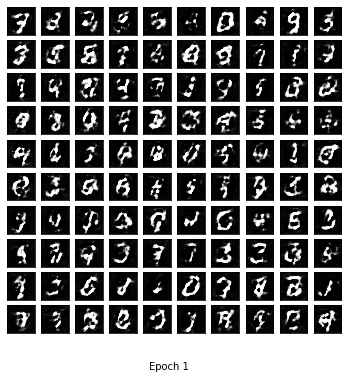

[2/40] - ptime: 25.05 loss_d: 0.348, loss_g: 2.825


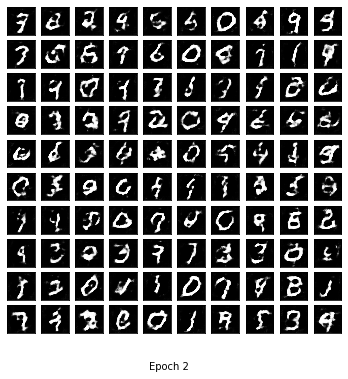

[3/40] - ptime: 24.92 loss_d: 0.374, loss_g: 2.878


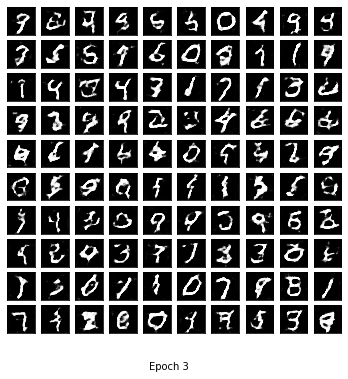

In [0]:
# optimizer for each network
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    D_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(D_loss, var_list=D_vars)
    G_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(G_loss, var_list=G_vars)

# open session and initialize all variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# MNIST resize and normalization
train_set = mnist.train.images
train_set = (train_set - 0.5) / 0.5  # normalization; range: -1 ~ 1

# results save folder
root = 'MNIST_DCGAN_results/'
model = 'MNIST_DCGAN_'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

# training-loop
np.random.seed(int(time.time()))
print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    G_losses = []
    D_losses = []
    epoch_start_time = time.time()
    shuffle_idxs = random.sample(range(0, train_set.shape[0]), train_set.shape[0])
    shuffled_set = train_set[shuffle_idxs]
    for iter in range(mnist.train.num_examples // batch_size):
        # update discriminator
        x_ = shuffled_set[iter*batch_size:(iter+1)*batch_size]
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))

        loss_d_, _ = sess.run([D_loss, D_optim], {x: x_, z: z_, isTrain: True})
        D_losses.append(loss_d_)

        # update generator
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))
        loss_g_, _ = sess.run([G_loss, G_optim], {z: z_, x: x_, isTrain: True})
        G_losses.append(loss_g_)

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print('[%d/%d] - ptime: %.2f loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, np.mean(D_losses), np.mean(G_losses)))
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    show_result((epoch + 1), save=True, path=fixed_p)
    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['per_epoch_ptimes']), train_epoch, total_ptime))
print("Training finish!... save training results")
with open(root + model + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path=root + model + 'train_hist.png')

images = []
for e in range(train_epoch):
    img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)

sess.close()